# Homework 2, *part 2* (60 points)

In this assignment you will build a convolutional neural net (CNN) to solve Tiny ImageNet image classification. Try to achieve as high accuracy as possible.

## Deliverables

* This file,
* a "checkpoint file" from `torch.save(model.state_dict(), ...)` that contains model's weights (which a TA should be able to load to verify your accuracy).

## Grading

* 9 points for reproducible training code and a filled report below.
* 12 points for building a network that gets above 20% accuracy.
* 6.5 points for beating each of these milestones on the private **test** set:
  * 25.0%
  * 30.0%
  * 32.5%
  * 35.0%
  * 37.5%
  * 40.0%
  
*Private test set* means that you won't be able to evaluate your model on it. Rather, after you submit code and checkpoint, we will load your model and evaluate it on that test set ourselves (so please make sure it's easy for TAs to do!), reporting your accuracy in a comment to the grade.
    
## Restrictions

* Don't use pretrained networks.

## Tips

* One change at a time: never test several new things at once.
* Google a lot.
* Use GPU.
* Use regularization: L2, batch normalization, dropout, data augmentation.
* Use Tensorboard ([non-Colab](https://github.com/lanpa/tensorboardX) or [Colab](https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6)) or a similar interactive tool for viewing progress.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.utils as vutils
import torch.optim as optim
from torch.optim import lr_scheduler
import time

In [2]:
import tiny_imagenet
tiny_imagenet.download(".")

./tiny-imagenet-200 already exists, not downloading


In [3]:
# def one_hot_encode(labels, max_label=199):
#     labels_one_hot = torch.zeros(labels.shape[0], max_label + 1)
#     labels_one_hot[torch.arange(labels.shape[0]), labels] = 1
    
#     return labels_one_hot

Training and validation images are now in `tiny-imagenet-200/train` and `tiny-imagenet-200/val`.

In [4]:
train_root = './tiny-imagenet-200/train'
val_root = './tiny-imagenet-200/val'

batch_size = 128
num_workers = 4
ngpu=1

log_interval = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)
print (torch.cuda.device_count())

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

cuda:0
1


In [5]:
train_data = datasets.ImageFolder(train_root,
                                  transform=transforms.Compose([#transforms.RandomResizedCrop(224),
                                                                #transforms.RandomHorizontalFlip(),
#                                                                 transforms.Resize(32),
                                                                transforms.RandomHorizontalFlip(),
                                                                transforms.RandomRotation(90),
#                                                                 transforms.CenterCrop(32),
                                                                transforms.ToTensor(),
                                                                normalize]))

train_data_loader = torch.utils.data.DataLoader(train_data, 
                                                batch_size=batch_size, 
                                                shuffle=True,
                                                num_workers=num_workers)

In [6]:
validation_data = datasets.ImageFolder(val_root,
                                       transform=transforms.Compose([
#                                                                      transforms.Resize(32),
                                                                     transforms.ToTensor(),
                                                                     normalize]))

# Create validation dataloader
validation_data_loader = torch.utils.data.DataLoader(validation_data,
                                                     batch_size=batch_size,
                                                     shuffle=False, num_workers=num_workers)

torch.Size([128, 3, 64, 64])


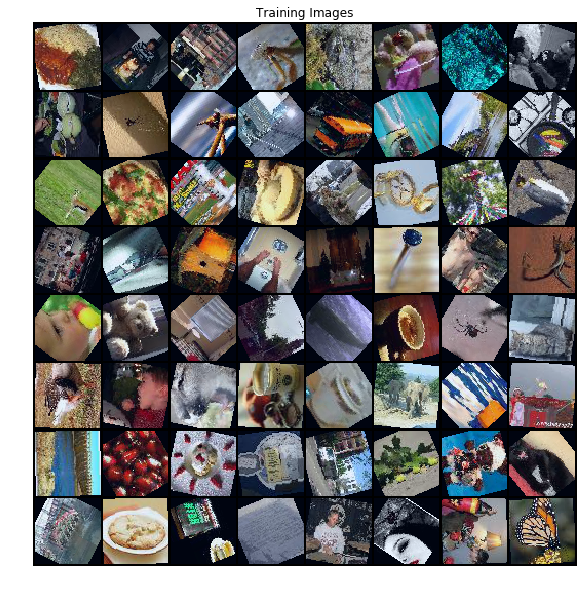

In [9]:
batch = next(iter(train_data_loader))
print (batch[0].shape)
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
#         self.classifier = nn.Linear(512, 200)
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 200)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
#         print (out.shape)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    


In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
#         nn.init.xavier_uniform_(m.weight.data)
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.xavier_uniform_(m.weight.data)
#         nn.init.normal_(m.weight.data, 1.0, 0.02)

In [12]:
net = VGG('VGG19')

if torch.cuda.is_available():
    net = net.cuda()
    if (ngpu > 1):
        net = nn.DataParallel(net, device_ids=list(range(ngpu)), output_device=device)
else:
    net = net.cpu()
    
net.apply(weights_init)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [13]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adadelta(net.parameters(), lr=1e-1, rho=0.95, eps=1e-8,
                           weight_decay=5e-4)

# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
def get_accuracy(outputs, labels):
    _, argmax = torch.max(outputs, 1)
    return (labels == argmax.squeeze()).float().mean()

def save_checkpoint(state, is_best, filename='./checkpoints/checkpoint_64x64.pth.tar'):
#     torch.save(state, filename)
    if is_best:
        filename = './checkpoints/model_best_64x64.pth.tar'
        
    torch.save(state, filename)

In [15]:
def train(epoch):
    net.train()
    running_loss = 0.
    running_accuracy = 0.
    for batch_idx, data in enumerate(train_data_loader):
        images, labels = data[0].type(torch.FloatTensor), data[1]
#         print (images.shape)
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        accuracy = get_accuracy(outputs, labels).item()
        running_accuracy += accuracy
#         print (outputs.shape)
#         print (labels.shape)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
#         if (batch_idx + 1) % log_interval == 0:
    running_accuracy /= len(train_data_loader)
    running_loss /= len(train_data_loader)
    print('\nTrain set: Loss: {:.4f}, Accuracy: {:.2f}%)\n'.format(
        running_loss, 100 * running_accuracy))
    running_loss = 0.
    running_accuracy = 0.
    net.train()

In [20]:
def valid():
    net.eval()
    valid_loss = 0.
    valid_accuracy = 0.
    correct = 0
    with torch.no_grad():
        for data in validation_data_loader:
            # break
            images, labels = data[0].type(torch.FloatTensor), data[1]
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            valid_loss += criterion(outputs, labels).item()
            valid_accuracy += get_accuracy(outputs, labels).item()
    valid_loss /= len(validation_data_loader)
    valid_accuracy /= len(validation_data_loader)
    print('\nValidation set: Loss: {:.4f}, Accuracy: {:.2f}%\n'.format(
        valid_loss, 100 * valid_accuracy))

    return valid_loss, valid_accuracy

In [ ]:
epochs = 10
best_accuracy = 0
_time = time.time()


checkpoint = torch.load('./checkpoints/model_best_64x64.pth.tar')
net.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
best_accuracy = checkpoint['best_prec1']

for epoch in range(1, epochs + 1):
    print("Epoch:", epoch)
    print("Train")
    train(epoch)
#     scheduler.step()
    print("Time:", time.time() - _time)
    if (epoch % 5 == 0):
        print("Validation:")
        _, accuracy = valid()
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            is_best = True
        else:
            is_best = False
        save_checkpoint({
            'epoch': epoch,
            'state_dict': net.state_dict(),
            'best_prec1': accuracy,
            'optimizer': optimizer.state_dict(),
        }, is_best)

In [18]:
checkpoint = torch.load('./checkpoints/model_best_64x64.pth.tar')
net.load_state_dict(checkpoint['state_dict'])
best_accuracy = checkpoint['best_prec1']
print ("Best accuracy: %.2f%%" % (best_accuracy * 100))

Best accuracy: 43.07%


When everything is done, please compute accuracy on the validation set and report it below.

In [21]:
_, val_accuracy = valid()
print("Validation accuracy: %.2f%%" % (val_accuracy * 100))


Validation set: Loss: 2.4903, Accuracy: 43.07%

Validation accuracy: 43.07%


# Report

Below, please mention

* a brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method (batch size, optimization algorithm, ...) and why?
* Any regularization and other techniques applied and their effects;

The reference format is:

*"I have analyzed these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such".*

**Architecture**

Final architecture is VGG19 [1] adapted for 64x64 images. In the original article there are no batch normalization layers, so they were added to speedup learning. Detailed scheme of the network you can see in one of the cells above.

[1] Very Deep Convolutional Networks for Large-Scale Image Recognition, <i>Karen Simonyan, Andrew Zisserman</i>

**Training method**

Final Setup: 

optimizer - <code>AdaDelta(lr=1e-1, rho=0.95, eps=1e-8, weight_decay=5e-4)</code>

batch size - <code>128</code>


As an optimizer was chosen AdaDelta with adaptive learning rate, default learning rate was set to $10^{-1}$, experiments have shown better convergence rate with such setup. At the beginning, SGD was used as an optimizer with manual adopting of learning rate. For such purposes learning scheduler was used. Different techniques were used, for example - decreasing of learning rate each 7th epoch, but such approaches have shown worst convergence rate.

**Techniques**

Different transformations were applied to training data set: 1) Random rotation (90 degrees), 2) Random horizontal flip, 3) Normalization with the widly used params: <code>(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])</code>. Without mentioned data augmentation performance was slightly worse, ~7% for accuracy on validation data set. 

**Tweaks and improvements**

At a first step I tried to downsample images to smaller size 32x32 and apply VGG for such images. Experements have shown best accuracy equal to <code>~32%</code> on validation data set (50 epochs). Accuracy and loss on train was much larger than on validation data set.

Logs for training: <b>logs.txt</b>